In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [7]:
news.to_csv("articles2.csv", encoding='utf-8', index=False)

Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [6]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [15]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [17]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [18]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [19]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [20]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

C:\Users\ENERGI~1\AppData\Local\Temp/ipykernel_14724/3066725202.py:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 34.2 s


In [21]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 4min 57s


А теперь в 3 строчки обучим нашу модель

In [22]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [23]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [36]:
len(common_dictionary), common_dictionary[10]

(141244, 'ватутин')

In [39]:
len(common_corpus), common_corpus[:2]

(27000,
 [[(0, 5),
   (1, 2),
   (2, 1),
   (3, 2),
   (4, 1),
   (5, 1),
   (6, 1),
   (7, 1),
   (8, 1),
   (9, 1),
   (10, 1),
   (11, 1),
   (12, 1),
   (13, 1),
   (14, 1),
   (15, 1),
   (16, 4),
   (17, 1),
   (18, 1),
   (19, 4),
   (20, 1),
   (21, 1),
   (22, 3),
   (23, 1),
   (24, 1),
   (25, 1),
   (26, 1),
   (27, 1),
   (28, 1),
   (29, 2),
   (30, 1),
   (31, 1),
   (32, 1),
   (33, 1),
   (34, 1),
   (35, 1),
   (36, 1),
   (37, 1),
   (38, 1),
   (39, 1),
   (40, 1),
   (41, 1),
   (42, 1),
   (43, 1),
   (44, 1),
   (45, 2),
   (46, 1),
   (47, 2),
   (48, 1),
   (49, 1),
   (50, 1),
   (51, 1),
   (52, 1),
   (53, 1),
   (54, 1),
   (55, 1),
   (56, 1),
   (57, 1),
   (58, 3),
   (59, 1),
   (60, 2),
   (61, 1),
   (62, 1),
   (63, 1),
   (64, 1),
   (65, 1),
   (66, 1),
   (67, 1),
   (68, 1),
   (69, 3),
   (70, 1),
   (71, 1),
   (72, 1),
   (73, 3),
   (74, 1),
   (75, 1),
   (76, 1),
   (77, 1),
   (78, 1),
   (79, 1),
   (80, 1),
   (81, 1),
   (82, 1),
   (83

Все просто - это словарь наших слов

Запускаем обучение

In [40]:
from gensim.models import LdaModel

In [41]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 1min 4s


In [42]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [43]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(0, 0.086977996),
 (11, 0.058448862),
 (13, 0.1289699),
 (14, 0.031826425),
 (18, 0.31654292),
 (23, 0.15140949),
 (24, 0.2096981)]

In [44]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: год газ стать nn первый это который
topic_1: фонд млн авария автомобиль кость образоваться составить
topic_2: это россия nn российский который мочь страна
topic_3: квартира налог налоговый ндс платёжный льгота лесной
topic_4: который земля человек nn это автор остров
topic_5: это nn который производитель памятник спрос культура
topic_6: это рост год страна россия научный который
topic_7: человек погибнуть тело произойти пострадать полиция результат
topic_8: ребёнок женщина человек это мочь мужчина который
topic_9: взрыв иск экипаж мышь выдать аэропорт следствие
topic_10: год это который рубль млрд человек также
topic_11: ракета год военный который это закон законопроект
topic_12: поверхность это космос общество запуск подчёркивать человеческий
topic_13: это который мочь пенсия год результат операция
topic_14: вицепремьер железный лауреат задать звание снять поспособствовать
topic_15: рак доля дыра это сообщество реакция финансы
topic_16: украина гражданин миссия nn ссср школа 

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [551]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [552]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]


topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.0,0.000000,0.0,0.043265,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.450073,0.034492,0.052225,0.000000
1,4896,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.257371,0.000000,0.283978
2,4897,0.087111,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.316535,0.0,0.0,0.000000,0.000000,0.151310,0.209686
3,4898,0.000000,0.0,0.000000,0.0,0.049591,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.154677,0.0,0.0,0.000000,0.039122,0.000000,0.082137
4,4899,0.000000,0.0,0.344411,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.507339,0.000000,0.000000,0.123079


Тут взвешиваем вектора статей в матрице topic_matrix

In [616]:
%%script_false
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer(norm='l1', use_idf=True, smooth_idf=False)

headers = list(topic_matrix)
tfidf = transformer.fit_transform(topic_matrix[headers[1:]])

tfidf = tfidf.toarray()
df = pd.DataFrame(tfidf)
df.head(5)

UsageError: Cell magic `%%script_false` not found.


In [617]:
%%script_false
for i in range(df.shape[1]):
    topic_matrix[f'topic_{i}'] = df[i]

topic_matrix.head(5)

UsageError: Cell magic `%%script_false` not found.


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [553]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [554]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [618]:
doc_dict[293622]

array([0.        , 0.        , 0.29655623, 0.        , 0.25336269,
       0.        , 0.        , 0.        , 0.07731166, 0.        ,
       0.        , 0.07907171, 0.        , 0.        , 0.        ,
       0.        , 0.06603418, 0.01731616, 0.19941562, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [640]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    
    transformer = TfidfTransformer(norm='l1', use_idf=True, smooth_idf=False)
    
#     print(user_vector)
    tfidf = transformer.fit_transform(user_vector)
#     print('*************************')
#     print(tfidf.toarray())
    
    user_vector = np.max(tfidf.toarray(), 0)
    return user_vector

In [641]:
get_user_embedding(user_articles_list)

C:\Users\Energizer\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1450: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


array([0.24299752, 0.        , 0.47135071, 0.        , 0.14790814,
       0.        , 0.18574926, 0.        , 0.12810538, 0.08403383,
       0.76805803, 0.29819052, 0.03630151, 0.08859796, 0.01656552,
       0.        , 0.13686638, 0.        , 0.04797433, 0.14834856,
       0.        , 0.21749553, 0.29496433, 0.13651775, 0.14358121])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [642]:
#users['articles'].iloc[33]

In [643]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [644]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.191351,0.0,0.341059,0.000000,0.200446,0.360887,0.085464,0.154882,0.073684,...,0.065481,0.471928,0.020456,0.363061,0.000000,0.224981,0.166842,0.386765,0.303114,0.000000
1,u108690,0.094375,0.0,0.310722,0.000000,0.058144,0.230082,0.336008,0.180530,0.163676,...,0.123986,0.122010,0.000000,0.120412,0.134555,0.087483,0.063060,0.119017,0.063977,0.025690
2,u108339,0.109568,0.0,0.340161,0.046803,0.028975,0.050752,0.132974,0.203026,0.046785,...,0.042143,0.046046,0.024469,0.075025,0.103277,0.062011,0.099366,0.260392,0.000000,0.115104


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [645]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [646]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.191351,0.0,0.341059,0.000000,0.200446,0.360887,0.085464,0.154882,0.073684,...,0.471928,0.020456,0.363061,0.000000,0.224981,0.166842,0.386765,0.303114,0.000000,0
1,u108690,0.094375,0.0,0.310722,0.000000,0.058144,0.230082,0.336008,0.180530,0.163676,...,0.122010,0.000000,0.120412,0.134555,0.087483,0.063060,0.119017,0.063977,0.025690,1
2,u108339,0.109568,0.0,0.340161,0.046803,0.028975,0.050752,0.132974,0.203026,0.046785,...,0.046046,0.024469,0.075025,0.103277,0.062011,0.099366,0.260392,0.000000,0.115104,1


In [647]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [648]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [649]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [650]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22365739, 0.00138945, 0.7397615 , 0.50496387, 0.01825396,
       0.01744382, 0.22946009, 0.00294369, 0.04117022, 0.33884099])

### Рассчитаем Precision, Recall, F_score

In [651]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [652]:
import itertools

In [653]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.308333, F-Score=0.787, Precision=0.743, Recall=0.837


In [654]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1684   71]
 [  41  204]]


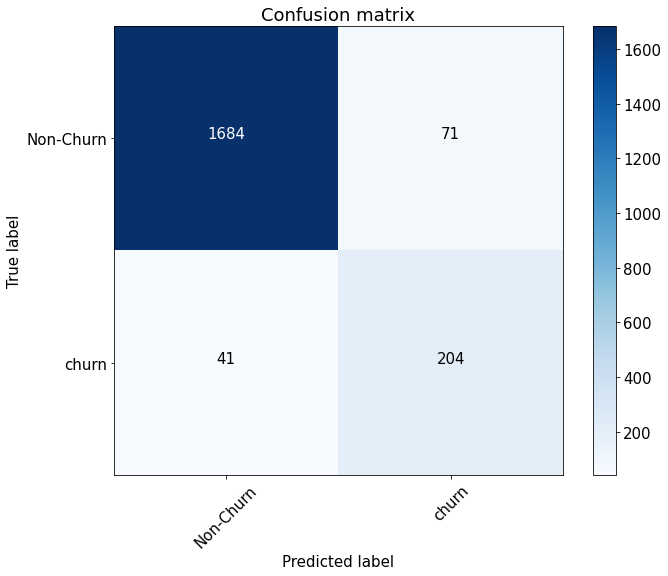

In [655]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [656]:
roc_auc_score(y_test, preds)

0.9770405256119542

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

**Задание 1**

done

**Задание 2-3**

способ вычисления - результат:
- np.mean (по умолчанию): Threshold=0.249248, F-Score=0.667, Precision=0.580, Recall=0.784, roc_auc_score=0.9368474911332054
- np.median:		Threshold=0.296594, F-Score=0.740, Precision=0.688, Recall=0.800, roc_auc_score=0.9597744054886913
- np.min: 		Threshold=0.170139, F-Score=0.517, Precision=0.508, Recall=0.527, roc_auc_score=0.8599976742833887
- np.max: 		Threshold=0.338495, F-Score=0.786, Precision=0.772, Recall=0.800, roc_auc_score=0.9732705389848247

In [346]:
cols = ["Count type", "Threshold", "F-Score", "Precision", "Recall", "roc_auc_score"]

In [347]:
data1 = [["np.mean (по умолчанию)", 0.249248, 0.667, 0.580, 0.784, 0.9368474911332054],
         ["np.median", 0.296594, 0.740, 0.688, 0.800, 0.9597744054886913],
         ["np.min", 0.170139, 0.517, 0.508, 0.527, 0.8599976742833887],
         ["np.max", 0.338495, 0.786, 0.772, 0.800, 0.9732705389848247]]

In [348]:
df1 = pd.DataFrame(data1, columns=cols)
df1

,Count type,Threshold,F-Score,Precision,Recall,roc_auc_score
0,np.mean (по умолчанию),0.249248,0.667,0.580,0.784,0.936847
1,np.median,0.296594,0.740,0.688,0.800,0.959774
2,np.min,0.170139,0.517,0.508,0.527,0.859998
3,np.max,0.338495,0.786,0.772,0.800,0.973271


Лучший результат показали вычисления со взятием максимального значения вероятности принадлежности к теме по статьям. Это может объясняться тем, что пользователь преимущественно читал статьи на темы, которые ему интересны, их вес в статьте превалирует и на их основе формировал мнение.

**Задание 4**

Значение вероятности тем для каждой статить из матрицы topic_matrix прогнал через TfidfTransformer с различными параметрами. Функцией расчета user_vector брал max(), т.к. он лучше всех себя показал в предыдущем задании.

способ вычисления - результат:
- TfidfTransformer(): Best Threshold=0.417532, F-Score=0.651, Precision=0.644, Recall=0.657, roc_auc_score=0.9402872260015118
- TfidfTransformer(norm='l1'): Best TThreshold=0.377591, F-Score=0.727, Precision=0.731, Recall=0.722, roc_auc_score=0.9570463399034829
- TfidfTransformer(norm='l1', use_idf=True, smooth_idf=False): Best TThreshold=0.327762, F-Score=0.778, Precision=0.743, Recall=0.816, roc_auc_score=0.973800802372231
- TfidfTransformer(norm='l1', use_idf=False, smooth_idf=True): Best Threshold=0.377591, F-Score=0.727, Precision=0.731, Recall=0.722, roc_auc_score=0.9570463399034829

In [599]:
data2 = [["1 - TfidfTransformer()", 0.417532, 0.651, 0.644, 0.657, 0.9402872260015118],
         ["1 - TfidfTransformer(norm='l1')", 0.377591, 0.727, 0.731, 0.722, 0.9570463399034829],
         ["1- TfidfTransformer(norm='l1', use_idf=True, smooth_idf=False)", 0.327762, 0.778, 0.743, 0.816, 0.973800802372231],
         ["1- TfidfTransformer(norm='l1', use_idf=False, smooth_idf=True)", 0.377591, 0.727, 0.731, 0.722, 0.9570463399034829]]

In [600]:
df2 = pd.DataFrame(data2, columns=cols)
df2

,Count type,Threshold,F-Score,Precision,Recall,roc_auc_score
0,1 - TfidfTransformer(),0.417532,0.651,0.644,0.657,0.940287
1,1 - TfidfTransformer(norm='l1'),0.377591,0.727,0.731,0.722,0.957046
2,"1- TfidfTransformer(norm='l1', use_idf=True, s...",0.327762,0.778,0.743,0.816,0.973801
3,"1- TfidfTransformer(norm='l1', use_idf=False, ...",0.377591,0.727,0.731,0.722,0.957046


Взвешивание статей из матрицы topic_matrix с использованием TfidfTransformer(norm='l1', use_idf=True, smooth_idf=False) дало немного лучшие результаты, чем просто взятие максимума при расчете user_vector

Отдельно попробовал взвешивать user_vector с помощью TfidfTransformer(). Т.е. в моем понимании - это взвешивание важности статей по темам для каждого конкретного пользователя из прочитанных им статей. Функцией выбора итогового значения user_vector брал также max().

способ вычисления - результат:
- TfidfTransformer(): Best Threshold=0.314315, F-Score=0.583, Precision=0.532, Recall=0.645, roc_auc_score=0.9732705389848247
- TfidfTransformer(norm='l1'): Best Threshold=0.301455, F-Score=0.786, Precision=0.738, Recall=0.841, roc_auc_score=0.9766614338042909
- TfidfTransformer(norm='l1', use_idf=True, smooth_idf=False): Best Threshold=0.284152, F-Score=0.793, Precision=0.731, Recall=0.865, roc_auc_score=0.9775079946508518
- TfidfTransformer(norm='l1', use_idf=False, smooth_idf=True): Best Threshold=0.335637, F-Score=0.782, Precision=0.761, Recall=0.804, roc_auc_score=0.9724193267050409

In [601]:
data3 = [["2 - TfidfTransformer()", 0.314315, 0.583, 0.532, 0.645, 0.9732705389848247],
         ["2 - TfidfTransformer(norm='l1')", 0.301455, 0.786, 0.738, 0.841, 0.9766614338042909],
         ["2 - TfidfTransformer(norm='l1', use_idf=True, smooth_idf=False)", 0.284152, 0.793, 0.731, 0.865, 0.9775079946508518],
         ["2 - TfidfTransformer(norm='l1', use_idf=False, smooth_idf=True)", 0.335637, 0.782, 0.761, 0.804, 0.9724193267050409]]

In [602]:
df3 = pd.DataFrame(data3, columns=cols)
df3

,Count type,Threshold,F-Score,Precision,Recall,roc_auc_score
0,2 - TfidfTransformer(),0.314315,0.583,0.532,0.645,0.973271
1,2 - TfidfTransformer(norm='l1'),0.301455,0.786,0.738,0.841,0.976661
2,"2 - TfidfTransformer(norm='l1', use_idf=True, ...",0.284152,0.793,0.731,0.865,0.977508
3,"2 - TfidfTransformer(norm='l1', use_idf=False,...",0.335637,0.782,0.761,0.804,0.972419


Ркзультаты получились даже лучше, чем со взвешиванием всех новостей.

In [603]:
df1['roc_auc_score'].max(), df2['roc_auc_score'].max(), df3['roc_auc_score'].max()

(0.9732705389848247, 0.973800802372231, 0.9775079946508518)

**Задание 5**

In [611]:
df = df1.append(df2, ignore_index=True)
df = df1.append(df3, ignore_index=True)
df

,Count type,Threshold,F-Score,Precision,Recall,roc_auc_score
0,np.mean (по умолчанию),0.249248,0.667,0.580,0.784,0.936847
1,np.median,0.296594,0.740,0.688,0.800,0.959774
2,np.min,0.170139,0.517,0.508,0.527,0.859998
3,np.max,0.338495,0.786,0.772,0.800,0.973271
4,2 - TfidfTransformer(),0.314315,0.583,0.532,0.645,0.973271
5,2 - TfidfTransformer(norm='l1'),0.301455,0.786,0.738,0.841,0.976661
6,"2 - TfidfTransformer(norm='l1', use_idf=True, ...",0.284152,0.793,0.731,0.865,0.977508
7,"2 - TfidfTransformer(norm='l1', use_idf=False,...",0.335637,0.782,0.761,0.804,0.972419


In [614]:
# Лучший результат
df.loc[df['roc_auc_score'] == df['roc_auc_score'].max()]

,Count type,Threshold,F-Score,Precision,Recall,roc_auc_score
6,"2 - TfidfTransformer(norm='l1', use_idf=True, ...",0.284152,0.793,0.731,0.865,0.977508


**Задание 6**

Наилучший результат показал вариант со взвешиванием user_vector с помощью TfidfTransformer() и выбором итогового максимума принадлежности к теме. Думаю, что подобный результат получен, т.к. для каждого конкретного пользователя имееют важность только те статьи (на соотвтествующие темы), которые он прочитал, а не все статьи, которые имеются в выборке. Т.е. свой выбор покинуть ресурс или остаться он делал именно на основании тех статей, которые он прочитал по интересующим его тематикам.